In [1]:
#from google.colab import drive
#drive.mount('/content/drive')
import sys
#PATH = '/content/drive/My Drive/PPM_Stability/'
#PATH = "C:/Users/velmurug/Documents/Stability Experiments/benchmark_interpretability/PPM_Stability/"
PATH = "C:/Users/mythr/Documents/GitHub/Stability-Experiments/benchmark_interpretability/PPM_Stability/"
sys.path.append(PATH)

In [2]:
#!pip install pandas==0.22.0
!pip install xgboost==1.0.0

In [3]:
import EncoderFactory
from DatasetManager import DatasetManager
import BucketFactory

import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support	

import time
import os
import sys
from sys import argv
import pickle
from collections import defaultdict

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

#import lime
#import lime.lime_tabular
#from lime import submodular_pick;
import warnings
warnings.filterwarnings('ignore')

import joblib
import random

In [4]:
def train_with_unbalanced_data(X_train, X_test, feature_combiner, dataset_manager, current_args, scaler = None, iterations = 10):
  #index = np.arange(0, len(y_train), 1)
  #X_train = X_train.reindex(index)

  all_pipelines = []
  all_cls = []
  all_acc = []

  for i in range(iterations):

    #X_train_enc = feature_combiner.fit_transform(X_train, y_train)

    y_train = dataset_manager.get_label_numeric(X_train)
    #print(len(y_train))
    case_ids = dataset_manager.get_case_ids(X_train)
    #print(case_ids.shape)

    #Reduce to balanced dataset
    neg_cases = [case_ids[i] for i in range(len(y_train)) if y_train[i] == 0]
    pos_cases = [case_ids[i] for i in range(len(y_train)) if y_train[i] == 1]
    
    if len(neg_cases) > len(pos_cases):
      to_keep = random.sample(neg_cases, len(pos_cases))
      X_train_resampled = X_train.loc[X_train[dataset_manager.case_id_col].isin(to_keep)]
      X_train_resampled = X_train_resampled.append(X_train.loc[X_train[dataset_manager.case_id_col].isin(pos_cases)])
    elif len(neg_cases) < len(pos_cases):
      to_keep = random.sample(neg_cases, len(pos_cases))
      X_train_resampled = X_train.loc[X_train[dataset_manager.case_id_col].isin(to_keep)]
      X_train_resampled = X_train_resampled.append(X_train.loc[X_train[dataset_manager.case_id_col].isin(neg_cases)])

    y_train_resampled = dataset_manager.get_label_numeric(X_train_resampled)

    #Train model
    if cls_method == "rf":
      cls = RandomForestClassifier(n_estimators=500,
                                  max_features=current_args['max_features'],
                                  random_state=random_state)

    elif cls_method == "xgboost":
      cls = xgb.XGBClassifier(objective='binary:logistic',
                              n_estimators=500,
                              learning_rate= current_args['learning_rate'],
                              subsample=current_args['subsample'],
                              max_depth=int(current_args['max_depth']),
                              colsample_bytree=current_args['colsample_bytree'],
                              min_child_weight=int(current_args['min_child_weight']),
                              seed=random_state)

    elif cls_method == "logit":
      cls = LogisticRegression(C=2**current_args['C'],
                              random_state=random_state)

    elif cls_method == "svm":
      cls = SVC(C=2**current_args['C'],
                gamma=2**current_args['gamma'],
                random_state=random_state)

    if cls_method == "svm" or cls_method == "logit":
      pipeline = Pipeline([('encoder', feature_combiner), ('scaler', StandardScaler()), ('cls', cls)])
    else:
      pipeline = Pipeline([('encoder', feature_combiner), ('cls', cls)])

    #print("fitting pipeline...")
    pipeline.fit(X_train_resampled, y_train_resampled)

    #Test Model
    test_all_grouped = dt_test_bucket.groupby(dataset_manager.case_id_col)
    y_test = [dataset_manager.get_label_numeric(group) for _,group in test_all_grouped]

    preds = pipeline.predict(X_test)
    #print(preds)
    acc = accuracy_score(y_test, preds)

    #save to list
    all_pipelines.append(pipeline)
    all_cls.append(cls)
    all_acc.append(acc)
  
  index = all_acc.index(max(all_acc))
    
  print("Accuracy Scores:", all_acc)
  print("Highest accuracy:", max(all_acc))
  print("Index:", index)

  pipeline = all_pipelines[index]
  cls = all_cls[index]

  return pipeline, cls

In [5]:
dataset_ref = "sepsis_cases"
params_dir = "params"
results_dir = "results"
bucket_method = "prefix"
cls_encoding = "agg"
cls_method = "xgboost"
gap = 1
n_iter = 1
balanced_data = False

if bucket_method == "state":
    bucket_encoding = "last"
else:
    bucket_encoding = "agg"

method_name = "%s_%s"%(bucket_method, cls_encoding)

dataset_ref_to_datasets = {
    #"bpic2011": ["bpic2011_f%s"%formula for formula in range(1,5)],
    "bpic2015": ["bpic2015_%s_f2"%(municipality) for municipality in range(5,6)],
    "bpic2017" : ["bpic2017_accepted"],
    "bpic2012" : ["bpic2012_accepted"],
    #"insurance": ["insurance_activity", "insurance_followup"],
    "sepsis_cases": ["sepsis_cases_1"]#, "sepsis_cases_2", "sepsis_cases_4"]
}

encoding_dict = {
    "laststate": ["static", "last"],
    "agg": ["static", "agg"],
    "index": ["static", "index"],
    "combined": ["static", "last", "agg"]
}

datasets = [dataset_ref] if dataset_ref not in dataset_ref_to_datasets else dataset_ref_to_datasets[dataset_ref]
methods = encoding_dict[cls_encoding]
    
train_ratio = 0.8
random_state = 22

# create results directory
if not os.path.exists(os.path.join(params_dir)):
    os.makedirs(os.path.join(params_dir))
    
print(datasets)

['sepsis_cases_1']


In [6]:
for dataset_name in datasets:
    
    # load optimal params
    print("Setting up parameters...")
    optimal_params_filename = os.path.join(PATH, params_dir, "optimal_params_%s_%s_%s.pickle" % (cls_method, dataset_name, method_name))

    if not os.path.isfile(optimal_params_filename) or os.path.getsize(optimal_params_filename) <= 0:
        print("Parameters not found")
        
    with open(optimal_params_filename, "rb") as fin:
        args = pickle.load(fin)
        
    print(args)
    bucket_list=[5,10,15,20,25] #:)	
            
    # read the data
    print("setting up data...")
    dataset_manager = DatasetManager(dataset_name)
    data = dataset_manager.read_dataset()

    #data = dataset_manager.balance_data(data)
    #print('Case ID column', dataset_manager.case_id_col)
    cls_encoder_args = {'case_id_col': dataset_manager.case_id_col, 
                        'static_cat_cols': dataset_manager.static_cat_cols,
                        'static_num_cols': dataset_manager.static_num_cols, 
                        'dynamic_cat_cols': dataset_manager.dynamic_cat_cols,
                        'dynamic_num_cols': dataset_manager.dynamic_num_cols, 
                        'fillna': True}

    # determine min and max (truncated) prefix lengths
    min_prefix_length = 1
    if "traffic_fines" in dataset_name:
        max_prefix_length = 10
    elif "bpic2017" in dataset_name:
        max_prefix_length = min(20, dataset_manager.get_pos_case_length_quantile(data, 0.90))
    else:
        max_prefix_length = min(40, dataset_manager.get_pos_case_length_quantile(data, 0.90))

    # split into training and test
    train, test = dataset_manager.split_data_strict(data, train_ratio, split="temporal")
    
    if gap > 1:
        outfile = os.path.join(results_dir, "performance_results_%s_%s_%s_gap%s.csv" % (cls_method, dataset_name, method_name, gap))
    else:
        outfile = os.path.join(results_dir, "performance_results_%s_%s_%s.csv" % (cls_method, dataset_name, method_name))
        
    start_test_prefix_generation = time.time()
    dt_test_prefixes = dataset_manager.generate_prefix_data(test, min_prefix_length, max_prefix_length)
    test_prefix_generation_time = time.time() - start_test_prefix_generation
            
    offline_total_times = []
    online_event_times = []
    train_prefix_generation_times = []

    for ii in range(n_iter):
        # create prefix logs
        print("Creating logs...")
        start_train_prefix_generation = time.time()
        dt_train_prefixes = dataset_manager.generate_prefix_data(train, min_prefix_length, max_prefix_length, gap)
        train_prefix_generation_time = time.time() - start_train_prefix_generation
        train_prefix_generation_times.append(train_prefix_generation_time)
            
        # Bucketing prefixes based on control flow
        print("bucketing prefixes...")
        bucketer_args = {'encoding_method':bucket_encoding, 
                        'case_id_col':dataset_manager.case_id_col, 
                        'cat_cols':[dataset_manager.activity_col], 
                        'num_cols':[], 
                        'random_state':random_state}
        if bucket_method == "cluster":
            bucketer_args["n_clusters"] = int(args["n_clusters"])
        bucketer = BucketFactory.get_bucketer(bucket_method, **bucketer_args)

        start_offline_time_bucket = time.time()
        bucket_assignments_train = bucketer.fit_predict(dt_train_prefixes)
        offline_time_bucket = time.time() - start_offline_time_bucket

        bucket_assignments_test = bucketer.predict(dt_test_prefixes)

        preds_all = []
        probas_all = []
        pred_types_all = []
        test_y_all = []
        nr_events_all = []
        offline_time_fit = 0
        current_online_event_times = []
        
        for bucket in set(bucket_assignments_test):
            print("Bucket" , bucket, "of", len(set(bucket_assignments_test)))
            print("sorting bucket...")
            #args has only one value - some error and so just using it
            #if bucket_method == "prefix":
            #    current_args = args[bucket]
            #else:
            current_args = args
            
            relevant_train_cases_bucket = dataset_manager.get_indexes(dt_train_prefixes)[bucket_assignments_train == bucket]
            relevant_test_cases_bucket = dataset_manager.get_indexes(dt_test_prefixes)[bucket_assignments_test == bucket]
            dt_test_bucket = dataset_manager.get_relevant_data_by_indexes(dt_test_prefixes, relevant_test_cases_bucket)
            
            nr_events_all.extend(list(dataset_manager.get_prefix_lengths(dt_test_bucket)))
            print('number events', len(nr_events_all))
            
            if len(relevant_train_cases_bucket) == 0:
                preds = [dataset_manager.get_class_ratio(train)] * len(relevant_test_cases_bucket)
                current_online_event_times.extend([0] * len(preds))
            
            else:
                dt_train_bucket = dataset_manager.get_relevant_data_by_indexes(dt_train_prefixes, relevant_train_cases_bucket) # one row per event
                train_y = dataset_manager.get_label_numeric(dt_train_bucket)
                test_y  = dataset_manager.get_label_numeric(dt_test_bucket)

                if len(set(train_y)) < 2:
                    preds = [train_y[0]] * len(relevant_test_cases_bucket)
                    current_online_event_times.extend([0] * len(preds))
                    test_y_all.extend(dataset_manager.get_label_numeric(dt_test_bucket))
                else:
                    print("choosing classifier...")
                    start_offline_time_fit = time.time()
                    feature_combiner = FeatureUnion([(method, EncoderFactory.get_encoder(method, **cls_encoder_args)) for method in methods])

                    if balanced_data==False:
                      pipeline, cls = train_with_unbalanced_data(dt_train_bucket, dt_test_bucket, feature_combiner, dataset_manager, current_args, iterations = 50)

                    else:
                      if cls_method == "rf":
                          cls = RandomForestClassifier(n_estimators=500,
                                                      max_features=current_args['max_features'],
                                                      random_state=random_state)

                      elif cls_method == "xgboost":
                          cls = xgb.XGBClassifier(objective='binary:logistic',
                                                  n_estimators=500,
                                                  learning_rate= current_args['learning_rate'],
                                                  subsample=current_args['subsample'],
                                                  max_depth=int(current_args['max_depth']),
                                                  colsample_bytree=current_args['colsample_bytree'],
                                                  min_child_weight=int(current_args['min_child_weight']),
                                                  seed=random_state)

                      elif cls_method == "logit":
                          cls = LogisticRegression(C=2**current_args['C'],
                                                  random_state=random_state)

                      elif cls_method == "svm":
                          cls = SVC(C=2**current_args['C'],
                                    gamma=2**current_args['gamma'],
                                    random_state=random_state)

                      if cls_method == "svm" or cls_method == "logit":
                          pipeline = Pipeline([('encoder', feature_combiner), ('scaler', StandardScaler()), ('cls', cls)])
                      else:
                          pipeline = Pipeline([('encoder', feature_combiner), ('cls', cls)])

                      print("fitting pipeline...")
                      pipeline.fit(dt_train_bucket, train_y)
                      
                      offline_time_fit += time.time() - start_offline_time_fit

            # predict separately for each prefix case
            preds = []
            probas = []
            pred_types = []
            
            test_all_grouped = dt_test_bucket.groupby(dataset_manager.case_id_col)
            print("test data shape", dt_test_bucket.shape)
            count_d=0 # count for deviant
            count_r=0 #count for regular

            tp_list = []
            tn_list = []
            fp_list = []
            fn_list = []

            iteration = 1
            
            for _, group in test_all_grouped:
                print ("Testing instance", iteration, 'of', len(test_all_grouped))
                test_y_group = dataset_manager.get_label_numeric(group)
                test_y_all.extend(test_y_group)
                    
                start = time.time()
                _ = bucketer.predict(group)
                
                if cls_method == "svm":
                    pred = pipeline.decision_function(group)
                else:
                  preds_pos_label_idx = np.where(cls.classes_ == 1)[0][0]
                  pred = pipeline.predict(group)[0]
                  proba = pipeline.predict_proba(group)[:,preds_pos_label_idx]
                pipeline_pred_time = time.time() - start
                current_online_event_times.append(pipeline_pred_time / len(group))
                case_id = dataset_manager.get_case_ids(group)[0]
                
                if test_y_group == pred & pred == 0:
                  pred_type = 'TN'

                  instance_dict = {}
                  instance_dict['caseID'] = case_id
                  instance_dict['input'] = group
                  instance_dict['actual'] = test_y_group[0]
                  instance_dict['predicted'] = pred
                  instance_dict['proba'] = 1 - proba[0]
                  instance_dict['nr_events'] = dataset_manager.get_prefix_lengths(group)[0]
                  instance_dict['pred_type'] = pred_type

                  tn_list.append(instance_dict)

                elif test_y_group == pred & pred == 1:
                  pred_type = 'TP'
                                    
                  instance_dict = {}
                  instance_dict['caseID'] = case_id
                  instance_dict['input'] = group
                  instance_dict['actual'] = test_y_group[0]
                  instance_dict['predicted'] = pred
                  instance_dict['proba'] = proba[0]
                  instance_dict['nr_events'] = dataset_manager.get_prefix_lengths(group)[0]
                  instance_dict['pred_type'] = pred_type

                  tp_list.append(instance_dict)

                elif test_y_group != pred & pred == 0:
                  pred_type = 'FN'
                  
                  instance_dict = {}
                  instance_dict['caseID'] = case_id
                  instance_dict['input'] = group
                  instance_dict['actual'] = test_y_group[0]
                  instance_dict['predicted'] = pred
                  instance_dict['proba'] = 1 - proba[0]
                  instance_dict['nr_events'] = dataset_manager.get_prefix_lengths(group)[0]
                  instance_dict['pred_type'] = pred_type

                  fn_list.append(instance_dict)

                elif test_y_group != pred & pred == 1:
                  pred_type = 'FP'
                  
                  instance_dict = {}
                  instance_dict['caseID'] = case_id
                  instance_dict['input'] = group
                  instance_dict['actual'] = test_y_group[0]
                  instance_dict['predicted'] = pred
                  instance_dict['proba'] = proba[0]
                  instance_dict['nr_events'] = dataset_manager.get_prefix_lengths(group)[0]
                  instance_dict['pred_type'] = pred_type

                  fp_list.append(instance_dict)
                else:
                  print("ERROR: Prediction doesn't fit into any category. Check code.")
                      
                preds.append(pred)
                probas.extend(proba)
                pred_types.append(pred_type)
                iteration+=1
                
            preds_all.extend(preds)
            probas_all.extend(probas)
            pred_types_all.extend(pred_types)

            tn_path = os.path.join(PATH, "%s/%s_%s/instances/true_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucket))
            tp_path = os.path.join(PATH, "%s/%s_%s/instances/true_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucket))
            fn_path = os.path.join(PATH, "%s/%s_%s/instances/false_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucket))
            fp_path = os.path.join(PATH, "%s/%s_%s/instances/false_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucket))
            
            with open (tn_path, 'wb') as f:
              pickle.dump(tn_list, f)
            with open (tp_path, 'wb') as f:
              pickle.dump(tp_list, f)
            with open (fn_path, 'wb') as f:
              pickle.dump(fn_list, f)
            with open (fp_path, 'wb') as f:
              pickle.dump(fp_list, f)

            #Save models and encoders
            print('Saving models...')
            pipeline_path = os.path.join(PATH, "%s/%s_%s/pipelines/pipeline_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucket))
            feat_comb_path = os.path.join(PATH, "%s/%s_%s/bucketers_and_encoders/feature_combiner_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucket))
            bucketer_path = os.path.join(PATH, "%s/%s_%s/bucketers_and_encoders/bucketer_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucket))
            cls_path = os.path.join(PATH, "%s/%s_%s/models/cls_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucket))
            joblib.dump(pipeline, pipeline_path)
            joblib.dump(feature_combiner, feat_comb_path)
            joblib.dump(cls, cls_path)
            joblib.dump(bucketer, bucketer_path)

            #Save training data
            print("saving data...")
            X_train_path = os.path.join(PATH, "%s/%s_%s/train_data/bucket_%s_prefixes.pickle" % (dataset_ref, cls_method, method_name, bucket))
            Y_train_path = os.path.join(PATH, "%s/%s_%s/train_data/bucket_%s_labels.pickle" % (dataset_ref, cls_method, method_name, bucket))
            with open(X_train_path, 'wb') as f:
              pickle.dump(dt_train_bucket, f)
            with open(Y_train_path, 'wb') as f:
              pickle.dump(train_y, f)

            #Save testing data
            X_test_path = os.path.join(PATH, "%s/%s_%s/test_data/bucket_%s_prefixes.pickle" % (dataset_ref, cls_method, method_name, bucket))
            Y_test_path = os.path.join(PATH, "%s/%s_%s/test_data/bucket_%s_labels.pickle" % (dataset_ref, cls_method, method_name, bucket))
            with open(X_test_path, 'wb') as f:
                pickle.dump(dt_test_bucket, f)
            with open(Y_test_path, 'wb') as f:
                pickle.dump(test_y_group, f)
      
        print("compiling results...")
        dt_results = pd.DataFrame({"actual": test_y_all, "predicted": preds_all, "nr_events": nr_events_all})
        for nr_events, group in dt_results.groupby("nr_events"):
            if len(set(group.actual)) < 2:
                print(dataset_name, method_name, cls_method, nr_events, "auc", np.nan)
            else:
                print(dataset_name, method_name, cls_method, nr_events, "auc", roc_auc_score(group.actual, group.predicted))
        print(dataset_name, method_name, cls_method, -1, -1, "auc", roc_auc_score(dt_results.actual, dt_results.predicted))


Setting up parameters...
{'colsample_bytree': 0.772671979273323, 'learning_rate': 0.09267082782802827, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.7794526804676039}
setting up data...
Creating logs...
bucketing prefixes...
prefix
Bucket 1 of 29
sorting bucket...
number events 157
choosing classifier...
Accuracy Scores: [0.4394904458598726, 0.40764331210191085, 0.40764331210191085, 0.445859872611465, 0.445859872611465, 0.4713375796178344, 0.3630573248407643, 0.4713375796178344, 0.37579617834394907, 0.3248407643312102, 0.3503184713375796, 0.42038216560509556, 0.4012738853503185, 0.45222929936305734, 0.3503184713375796, 0.4394904458598726, 0.3885350318471338, 0.31210191082802546, 0.4267515923566879, 0.3503184713375796, 0.42038216560509556, 0.4140127388535032, 0.29936305732484075, 0.45222929936305734, 0.42038216560509556, 0.3503184713375796, 0.34394904458598724, 0.46496815286624205, 0.34394904458598724, 0.43312101910828027, 0.37579617834394907, 0.3057324840764331, 0.5222929936305

Testing instance 49 of 157
Testing instance 50 of 157
Testing instance 51 of 157
Testing instance 52 of 157
Testing instance 53 of 157
Testing instance 54 of 157
Testing instance 55 of 157
Testing instance 56 of 157
Testing instance 57 of 157
Testing instance 58 of 157
Testing instance 59 of 157
Testing instance 60 of 157
Testing instance 61 of 157
Testing instance 62 of 157
Testing instance 63 of 157
Testing instance 64 of 157
Testing instance 65 of 157
Testing instance 66 of 157
Testing instance 67 of 157
Testing instance 68 of 157
Testing instance 69 of 157
Testing instance 70 of 157
Testing instance 71 of 157
Testing instance 72 of 157
Testing instance 73 of 157
Testing instance 74 of 157
Testing instance 75 of 157
Testing instance 76 of 157
Testing instance 77 of 157
Testing instance 78 of 157
Testing instance 79 of 157
Testing instance 80 of 157
Testing instance 81 of 157
Testing instance 82 of 157
Testing instance 83 of 157
Testing instance 84 of 157
Testing instance 85 of 157
T

Testing instance 147 of 157
Testing instance 148 of 157
Testing instance 149 of 157
Testing instance 150 of 157
Testing instance 151 of 157
Testing instance 152 of 157
Testing instance 153 of 157
Testing instance 154 of 157
Testing instance 155 of 157
Testing instance 156 of 157
Testing instance 157 of 157
Saving models...
saving data...
Bucket 4 of 29
sorting bucket...
number events 628
choosing classifier...
Accuracy Scores: [0.3375796178343949, 0.37579617834394907, 0.3248407643312102, 0.37579617834394907, 0.3821656050955414, 0.42038216560509556, 0.3503184713375796, 0.3885350318471338, 0.267515923566879, 0.3821656050955414, 0.3503184713375796, 0.4394904458598726, 0.34394904458598724, 0.3503184713375796, 0.3630573248407643, 0.4140127388535032, 0.40764331210191085, 0.3885350318471338, 0.43312101910828027, 0.4140127388535032, 0.445859872611465, 0.3184713375796178, 0.42038216560509556, 0.3248407643312102, 0.29936305732484075, 0.42038216560509556, 0.445859872611465, 0.33121019108280253, 0

Testing instance 45 of 157
Testing instance 46 of 157
Testing instance 47 of 157
Testing instance 48 of 157
Testing instance 49 of 157
Testing instance 50 of 157
Testing instance 51 of 157
Testing instance 52 of 157
Testing instance 53 of 157
Testing instance 54 of 157
Testing instance 55 of 157
Testing instance 56 of 157
Testing instance 57 of 157
Testing instance 58 of 157
Testing instance 59 of 157
Testing instance 60 of 157
Testing instance 61 of 157
Testing instance 62 of 157
Testing instance 63 of 157
Testing instance 64 of 157
Testing instance 65 of 157
Testing instance 66 of 157
Testing instance 67 of 157
Testing instance 68 of 157
Testing instance 69 of 157
Testing instance 70 of 157
Testing instance 71 of 157
Testing instance 72 of 157
Testing instance 73 of 157
Testing instance 74 of 157
Testing instance 75 of 157
Testing instance 76 of 157
Testing instance 77 of 157
Testing instance 78 of 157
Testing instance 79 of 157
Testing instance 80 of 157
Testing instance 81 of 157
T

Testing instance 143 of 157
Testing instance 144 of 157
Testing instance 145 of 157
Testing instance 146 of 157
Testing instance 147 of 157
Testing instance 148 of 157
Testing instance 149 of 157
Testing instance 150 of 157
Testing instance 151 of 157
Testing instance 152 of 157
Testing instance 153 of 157
Testing instance 154 of 157
Testing instance 155 of 157
Testing instance 156 of 157
Testing instance 157 of 157
Saving models...
saving data...
Bucket 7 of 29
sorting bucket...
number events 1099
choosing classifier...
Accuracy Scores: [0.5031847133757962, 0.5095541401273885, 0.42038216560509556, 0.4713375796178344, 0.46496815286624205, 0.5222929936305732, 0.40764331210191085, 0.5159235668789809, 0.4140127388535032, 0.4140127388535032, 0.4012738853503185, 0.47770700636942676, 0.4713375796178344, 0.4267515923566879, 0.35668789808917195, 0.4968152866242038, 0.4140127388535032, 0.5222929936305732, 0.36942675159235666, 0.4394904458598726, 0.4968152866242038, 0.43312101910828027, 0.420382

Testing instance 41 of 157
Testing instance 42 of 157
Testing instance 43 of 157
Testing instance 44 of 157
Testing instance 45 of 157
Testing instance 46 of 157
Testing instance 47 of 157
Testing instance 48 of 157
Testing instance 49 of 157
Testing instance 50 of 157
Testing instance 51 of 157
Testing instance 52 of 157
Testing instance 53 of 157
Testing instance 54 of 157
Testing instance 55 of 157
Testing instance 56 of 157
Testing instance 57 of 157
Testing instance 58 of 157
Testing instance 59 of 157
Testing instance 60 of 157
Testing instance 61 of 157
Testing instance 62 of 157
Testing instance 63 of 157
Testing instance 64 of 157
Testing instance 65 of 157
Testing instance 66 of 157
Testing instance 67 of 157
Testing instance 68 of 157
Testing instance 69 of 157
Testing instance 70 of 157
Testing instance 71 of 157
Testing instance 72 of 157
Testing instance 73 of 157
Testing instance 74 of 157
Testing instance 75 of 157
Testing instance 76 of 157
Testing instance 77 of 157
T

Testing instance 139 of 154
Testing instance 140 of 154
Testing instance 141 of 154
Testing instance 142 of 154
Testing instance 143 of 154
Testing instance 144 of 154
Testing instance 145 of 154
Testing instance 146 of 154
Testing instance 147 of 154
Testing instance 148 of 154
Testing instance 149 of 154
Testing instance 150 of 154
Testing instance 151 of 154
Testing instance 152 of 154
Testing instance 153 of 154
Testing instance 154 of 154
Saving models...
saving data...
Bucket 10 of 29
sorting bucket...
number events 1562
choosing classifier...
Accuracy Scores: [0.4144736842105263, 0.3618421052631579, 0.4473684210526316, 0.4473684210526316, 0.506578947368421, 0.4276315789473684, 0.42105263157894735, 0.4342105263157895, 0.375, 0.46710526315789475, 0.48026315789473684, 0.4276315789473684, 0.5723684210526315, 0.4868421052631579, 0.45394736842105265, 0.48026315789473684, 0.3815789473684211, 0.42105263157894735, 0.4868421052631579, 0.3355263157894737, 0.40789473684210525, 0.52631578947

Testing instance 47 of 141
Testing instance 48 of 141
Testing instance 49 of 141
Testing instance 50 of 141
Testing instance 51 of 141
Testing instance 52 of 141
Testing instance 53 of 141
Testing instance 54 of 141
Testing instance 55 of 141
Testing instance 56 of 141
Testing instance 57 of 141
Testing instance 58 of 141
Testing instance 59 of 141
Testing instance 60 of 141
Testing instance 61 of 141
Testing instance 62 of 141
Testing instance 63 of 141
Testing instance 64 of 141
Testing instance 65 of 141
Testing instance 66 of 141
Testing instance 67 of 141
Testing instance 68 of 141
Testing instance 69 of 141
Testing instance 70 of 141
Testing instance 71 of 141
Testing instance 72 of 141
Testing instance 73 of 141
Testing instance 74 of 141
Testing instance 75 of 141
Testing instance 76 of 141
Testing instance 77 of 141
Testing instance 78 of 141
Testing instance 79 of 141
Testing instance 80 of 141
Testing instance 81 of 141
Testing instance 82 of 141
Testing instance 83 of 141
T

Testing instance 2 of 109
Testing instance 3 of 109
Testing instance 4 of 109
Testing instance 5 of 109
Testing instance 6 of 109
Testing instance 7 of 109
Testing instance 8 of 109
Testing instance 9 of 109
Testing instance 10 of 109
Testing instance 11 of 109
Testing instance 12 of 109
Testing instance 13 of 109
Testing instance 14 of 109
Testing instance 15 of 109
Testing instance 16 of 109
Testing instance 17 of 109
Testing instance 18 of 109
Testing instance 19 of 109
Testing instance 20 of 109
Testing instance 21 of 109
Testing instance 22 of 109
Testing instance 23 of 109
Testing instance 24 of 109
Testing instance 25 of 109
Testing instance 26 of 109
Testing instance 27 of 109
Testing instance 28 of 109
Testing instance 29 of 109
Testing instance 30 of 109
Testing instance 31 of 109
Testing instance 32 of 109
Testing instance 33 of 109
Testing instance 34 of 109
Testing instance 35 of 109
Testing instance 36 of 109
Testing instance 37 of 109
Testing instance 38 of 109
Testing i

Testing instance 27 of 78
Testing instance 28 of 78
Testing instance 29 of 78
Testing instance 30 of 78
Testing instance 31 of 78
Testing instance 32 of 78
Testing instance 33 of 78
Testing instance 34 of 78
Testing instance 35 of 78
Testing instance 36 of 78
Testing instance 37 of 78
Testing instance 38 of 78
Testing instance 39 of 78
Testing instance 40 of 78
Testing instance 41 of 78
Testing instance 42 of 78
Testing instance 43 of 78
Testing instance 44 of 78
Testing instance 45 of 78
Testing instance 46 of 78
Testing instance 47 of 78
Testing instance 48 of 78
Testing instance 49 of 78
Testing instance 50 of 78
Testing instance 51 of 78
Testing instance 52 of 78
Testing instance 53 of 78
Testing instance 54 of 78
Testing instance 55 of 78
Testing instance 56 of 78
Testing instance 57 of 78
Testing instance 58 of 78
Testing instance 59 of 78
Testing instance 60 of 78
Testing instance 61 of 78
Testing instance 62 of 78
Testing instance 63 of 78
Testing instance 64 of 78
Testing inst

Testing instance 27 of 38
Testing instance 28 of 38
Testing instance 29 of 38
Testing instance 30 of 38
Testing instance 31 of 38
Testing instance 32 of 38
Testing instance 33 of 38
Testing instance 34 of 38
Testing instance 35 of 38
Testing instance 36 of 38
Testing instance 37 of 38
Testing instance 38 of 38
Saving models...
saving data...
Bucket 19 of 29
sorting bucket...
number events 2292
choosing classifier...
Accuracy Scores: [0.3888888888888889, 0.2777777777777778, 0.5, 0.4166666666666667, 0.3888888888888889, 0.5, 0.3333333333333333, 0.4444444444444444, 0.4722222222222222, 0.4722222222222222, 0.4444444444444444, 0.5277777777777778, 0.4722222222222222, 0.4444444444444444, 0.4166666666666667, 0.5277777777777778, 0.19444444444444445, 0.3333333333333333, 0.3888888888888889, 0.5555555555555556, 0.5, 0.3333333333333333, 0.3055555555555556, 0.4722222222222222, 0.3333333333333333, 0.4166666666666667, 0.5833333333333334, 0.5555555555555556, 0.5, 0.4722222222222222, 0.5, 0.61111111111111

Testing instance 2 of 21
Testing instance 3 of 21
Testing instance 4 of 21
Testing instance 5 of 21
Testing instance 6 of 21
Testing instance 7 of 21
Testing instance 8 of 21
Testing instance 9 of 21
Testing instance 10 of 21
Testing instance 11 of 21
Testing instance 12 of 21
Testing instance 13 of 21
Testing instance 14 of 21
Testing instance 15 of 21
Testing instance 16 of 21
Testing instance 17 of 21
Testing instance 18 of 21
Testing instance 19 of 21
Testing instance 20 of 21
Testing instance 21 of 21
Saving models...
saving data...
Bucket 24 of 29
sorting bucket...
number events 2416
choosing classifier...
Accuracy Scores: [0.5263157894736842, 0.42105263157894735, 0.5789473684210527, 0.5789473684210527, 0.3157894736842105, 0.47368421052631576, 0.3157894736842105, 0.7368421052631579, 0.5789473684210527, 0.5789473684210527, 0.5789473684210527, 0.6842105263157895, 0.631578947368421, 0.5263157894736842, 0.3157894736842105, 0.47368421052631576, 0.47368421052631576, 0.47368421052631576

Testing instance 2 of 13
Testing instance 3 of 13
Testing instance 4 of 13
Testing instance 5 of 13
Testing instance 6 of 13
Testing instance 7 of 13
Testing instance 8 of 13
Testing instance 9 of 13
Testing instance 10 of 13
Testing instance 11 of 13
Testing instance 12 of 13
Testing instance 13 of 13
Saving models...
saving data...
compiling results...
sepsis_cases_1 prefix_agg xgboost 1 auc 0.4586330935251798
sepsis_cases_1 prefix_agg xgboost 2 auc 0.37889688249400477
sepsis_cases_1 prefix_agg xgboost 3 auc 0.37070343725019983
sepsis_cases_1 prefix_agg xgboost 4 auc 0.41806554756195047
sepsis_cases_1 prefix_agg xgboost 5 auc 0.5455635491606714
sepsis_cases_1 prefix_agg xgboost 6 auc 0.5583533173461231
sepsis_cases_1 prefix_agg xgboost 7 auc 0.4638289368505196
sepsis_cases_1 prefix_agg xgboost 8 auc 0.5115907274180655
sepsis_cases_1 prefix_agg xgboost 9 auc 0.5833333333333333
sepsis_cases_1 prefix_agg xgboost 10 auc 0.47802653399668327
sepsis_cases_1 prefix_agg xgboost 11 auc 0.51325

<AxesSubplot:>

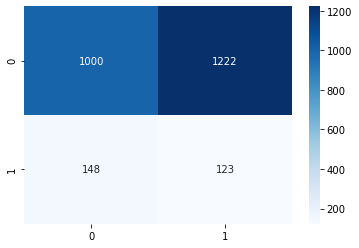

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf = confusion_matrix(test_y_all, preds_all)
#conf = conf/conf.astype(np.float).sum(axis=1)
sns.heatmap(conf, annot=True,fmt = 'd', cmap='Blues')